In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import root

%matplotlib inline

## DE for the Damped Pendulum

In [2]:
def y_prime(t, y, b):
    return np.array([
        y[1],
        -(b * y[1] + np.sin(y[0])),
    ])

## Explicit vs. Implicit Euler Methods

In [3]:
# General constant step-size Euler method: explicit, implicit, or their combination,
# depending on the value of lambda (`lam`), i.e. the weight of the explicit step.
def general_euler(y_prime, y0, t_span, h, lam, args):
    y   = np.array(y0, dtype=float)
    ts  = np.arange(t_span[0], t_span[1] + h, h)
    ys  = np.empty((len(y0), len(ts)))

    for i, t in enumerate(ts):
        ys[:, i] = y

        # Explicit part: y_{k+1} = y_k + h * y'_k
        y_expl = y + h * y_prime(t, y, *args)
        # Implicit part: solve `y_{k+1} = y_k + h * y'_{k+1}`
        # with notation y = y_k and x = y_{k+1}
        y_impl = root(lambda x: y + h * y_prime(t, x, *args) - x, x0=y).x

        # Compute y_{k+1} as a trade-off between the explicit and the implicit computation
        y = lam * y_expl + (1 - lam) * y_impl

    return ts, ys

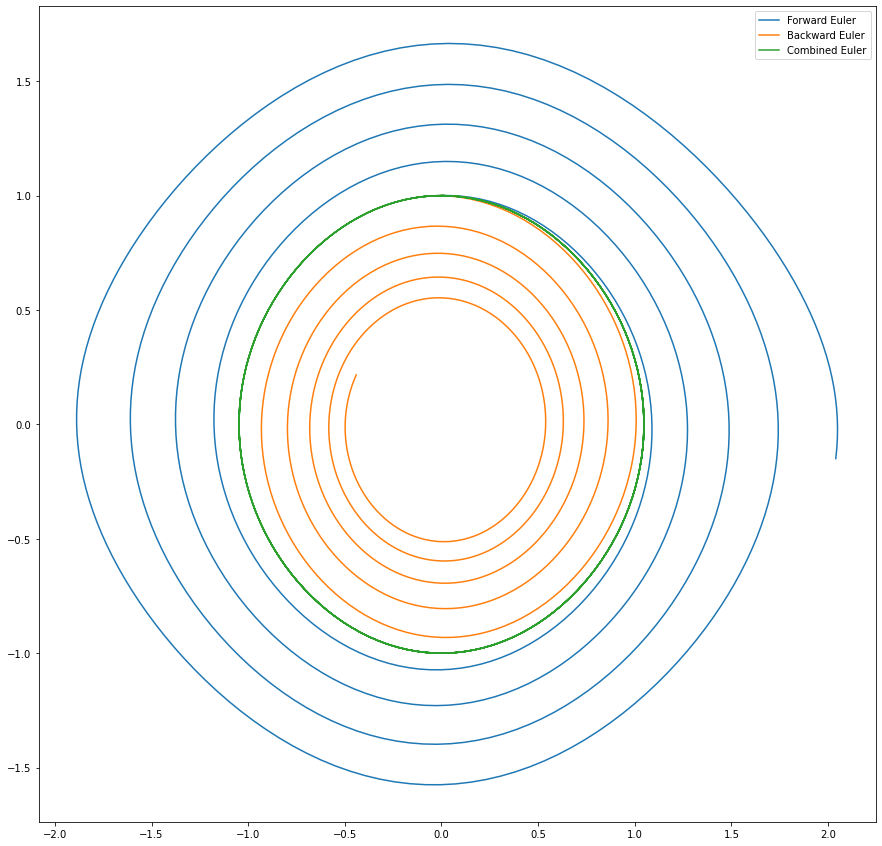

In [4]:
_, ys_fwd = general_euler(y_prime, y0=[0, 1], t_span=(0, 10 * np.pi), h=0.05, lam=1.0, args=(0,))
_, ys_bck = general_euler(y_prime, y0=[0, 1], t_span=(0, 10 * np.pi), h=0.05, lam=0.0, args=(0,))
_, ys_com = general_euler(y_prime, y0=[0, 1], t_span=(0, 10 * np.pi), h=0.05, lam=0.5, args=(0,))

plt.figure(figsize=(15, 15))

sns.lineplot(ys_fwd[0], ys_fwd[1], sort=False, label='Forward Euler')
sns.lineplot(ys_bck[0], ys_bck[1], sort=False, label='Backward Euler')
sns.lineplot(ys_com[0], ys_com[1], sort=False, label='Combined Euler')

## Approaching Stable and Unstable Manifolds near a Saddle Point
### (And the Technique of Time Reversal)

In [5]:
def evolve_manifold(y_prime, y0s, tf, t_eval, num_points, args):
    # Dimensions of the output tensor:
    # 1. number of points (i.e. resolution of the discretized line of initial conditions)
    # 2. number of equations (i.e. dimension of the system) == number of columns of initial conditions
    # 3. number of time steps (i.e. resolution of time)
    ys = np.empty((num_points + 1, y0s.shape[1], len(t_eval)))

    for i in range(num_points + 1):
        # Parametric equation of the line through the two endpoints.
        # This yields a specific point `(y, y')` on the line.
        lam = i / num_points
        y0 = (1 - lam) * y0s[0, :] + lam * y0s[1, :]

        # Compute the time evolution of this point.
        res = solve_ivp(y_prime, t_span=(0, tf), y0=y0, t_eval=t_eval, args=args)
        ys[i, :, :] = res.y
    
    return ys

### First, try approaching the _unstable_ invariant manifold (axis) with an expanding line

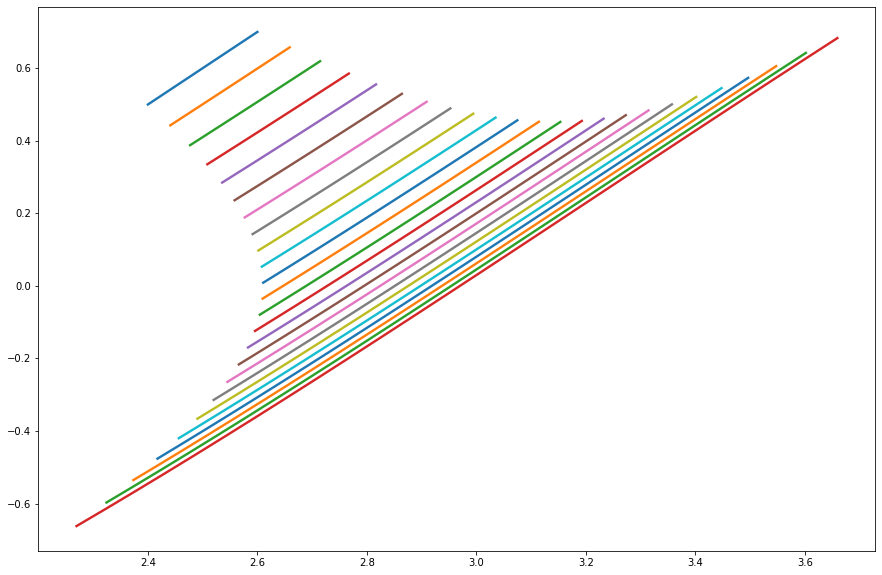

In [6]:
y0s = np.array([
    [2.4, 0.5], # first endpoint of line of initial conditions y, y'
    [2.6, 0.7], # second endpoint of line of initial conditions y, y'
])
tf = 2.0

ys = evolve_manifold(
    y_prime,
    y0s=y0s,
    tf=tf,
    t_eval=np.linspace(0, tf, num=24),
    num_points=24,
    args=(0,)
)

plt.figure(figsize=(15, 10))

for y in ys.T: # At each time step, plot the evolved points
    # sns.scatterplot(y[0], y[1], edgecolor=None, s=12)
    sns.lineplot(y[0], y[1], sort=False, linewidth=2.4)

### Now, use time reversal for approaching the _stable_ invariant manifold

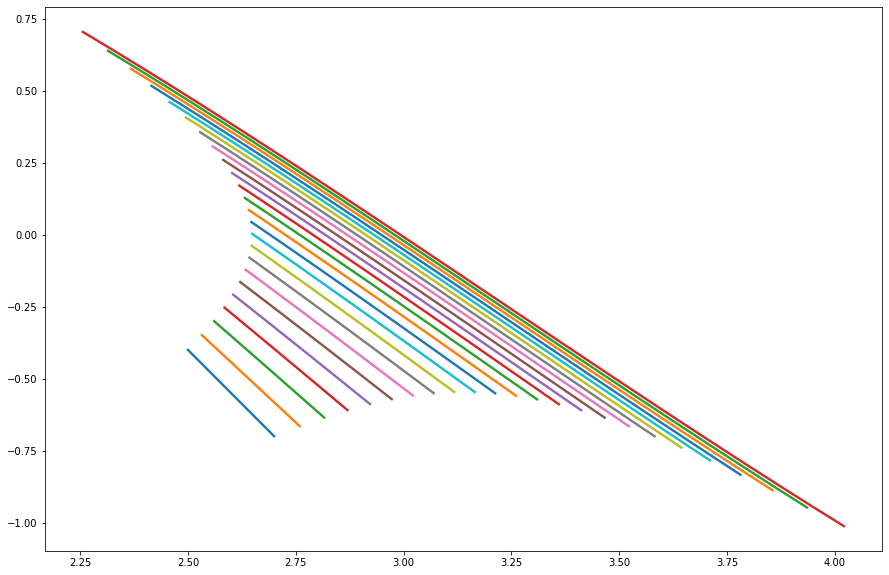

In [7]:
y0s = np.array([
    [2.5, -0.4], # first endpoint of line of initial conditions y, y'
    [2.7, -0.7], # second endpoint of line of initial conditions y, y'
])
tf = 2.0

ys = evolve_manifold(
    y_prime=lambda t, y, b: -y_prime(t, y, b), # Time Reversal: y' = -f(t, y; b)
    y0s=y0s,
    tf=tf,
    t_eval=np.linspace(0, tf, num=24),
    num_points=24,
    args=(0,)
)

plt.figure(figsize=(15, 10))

for y in ys.T: # At each time step, plot the evolved points
    # sns.scatterplot(y[0], y[1], edgecolor=None, s=12)
    sns.lineplot(y[0], y[1], sort=False, linewidth=2.4)